In [203]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [225]:
# the approach here is to numerically simulate as a function of light intensity and time
# the fraction of a population of ion channels that are open, based on first order kinetics, 
# and to use that as the input to a conductance based neuron model with some fixed leak conductance. 
# The result will be a simulated depolarization PSF, in mV, as a function of offset from the
# target center in z.
dt = 0.01 # granularity of the simulation in ms; this should be small
tmax = 50 # number of ms to simulate
t = np.linspace(0,tmax,tmax/dt+1)
Nt = t.size
dintensity = 0.001 # granularity of light intensities to simulate; this should be small
intensitymax = 3 # maximum RMS intensity to test, in units of 1/sqrt(opsin two photon action cross section* opsin tau off)
intensity = np.linspace(0,intensitymax,intensitymax/dintensity+1)
Ni = intensity.size
tauoff = 10 # 1/(opsin tau off in ms)
tauinact = 100 # 1/(opsin inactivation time const in ms)
taureact = 100 # 1/(opsin return to ground state time const in ms)
gmax = 0.2 # conductance with all channels open, in units of membrane capacitance/ms
gL = 0.1 # leak conductance of the cell, in units of membrane capacitance/ms. This is 1/(membrane time const in ms).
Vrest = -70 # resting membrane potential in mV
Ec = 0 # opsin reversal potential in mV

Copen = np.zeros((Nt,Ni)) # vector of the fraction open channels over time and intensity
Cinactive = np.zeros((Nt,Ni)) # vector of the fraction open channels over time and intensity
V = Vrest*np.ones((Nt,Ni)) # vector of cell membrane voltage over time and intensity, in mV
koff = 1/tauoff
kinact = 1/tauinact
kreact = 1/taureact

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


In [226]:
# closed <-> open -> inactive -> closed 
for i,time in enumerate(t[:-1]):
    # first order kinetics a two-state model and two photon absorption
    Cclosed = 1-Copen[i]-Cinactive[i]
    Copen[i+1] = Copen[i] + dt*intensity**2*Cclosed - dt*koff*Copen[i] - dt*kinact*Copen[i]
    Cinactive[i+1] = Cinactive[i] + dt*koff*Copen[i] - dt*kreact*Cinactive[i]

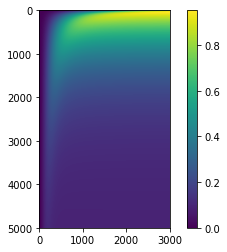

In [227]:
plt.figure()
plt.imshow(Copen)
plt.colorbar()

In [228]:
for i,time in enumerate(t[:-1]):
    # conductance based membrane voltage model, defined relative to 
    V[i+1] = V[i] + dt*gmax*Copen[i]*(Ec-V[i]) + dt*gL*(Vrest-V[i])

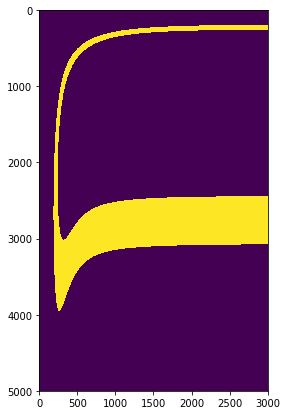

In [229]:
plt.figure(figsize=(10,7))
thresh = -50 # look for time until cell depolarizes to this voltage, in mV
plt.imshow(np.abs(V-thresh)<2)


In [230]:
def lorentzian(z,zR=1):
    return 1/(1+(z/zR)**2)

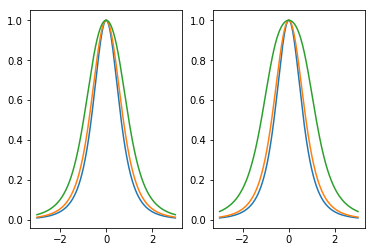

In [240]:
# assuming a Lorentzian point spread function, plot depolarization vs. z (in units of FWHM/2)
# for various choice of dwell time and light intensity

plt.figure()
plt.subplot(1,2,1)
# t = 100
z = np.linspace(-3,3,1000)
for time in (10,100,300):
    vals = np.interp(lorentzian(z),intensity,V[time,:])
    plt.plot(z,(vals-Vrest)/(vals-Vrest).max())
    
plt.subplot(1,2,2)
time = 100
z = np.linspace(-3,3,1000)
for i in (0.1,1,2.6):
    vals = np.interp(i*lorentzian(z),intensity,V[time,:])
    plt.plot(z,(vals-Vrest)/(vals-Vrest).max())

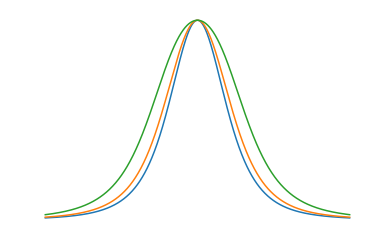

In [246]:
z = np.linspace(-3,3,1000)
for time in (10,100,300):
    vals = np.interp(lorentzian(z),intensity,V[time,:])
    plt.plot(z,(vals-Vrest)/(vals-Vrest).max())
    plt.axis('off')
plt.savefig('fwhm_over_time.eps')

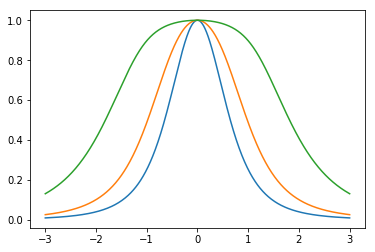

In [247]:
z = np.linspace(-3,3,1000)
for i in (0.1,1,2.6):
    vals = np.interp(i*lorentzian(z),intensity,V[time,:])
    plt.plot(z,(vals-Vrest)/(vals-Vrest).max())
plt.savefig('fwhm_over_intensity.eps')

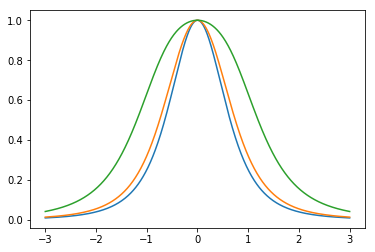

In [236]:
time = 100
z = np.linspace(-3,3,1000)
for i in (0.1,1,2.6):
    vals = np.interp(i*lorentzian(z),intensity,V[time,:])
    plt.plot(z,(vals-Vrest)/(vals-Vrest).max())

In [163]:
def compute_fwhm(thisintensityind,thistimeind):
    Vmax = V[thistimeind,thisintensityind] # depolarization at focus
    intensityhalfmax = np.interp(Vrest+(Vmax-Vrest)/2,V[thistimeind,:],intensity) # intensity corresponding to half maximal depolarization
    zhalfmax = np.interp(intensityhalfmax/intensity[thisintensityind],lorentzian(z[z>0])[::-1],z[z>0][::-1])
    return zhalfmax

In [164]:
np.interp(0.5,lorentzian(z[z>0])[::-1],z[z>0][::-1])

1.0

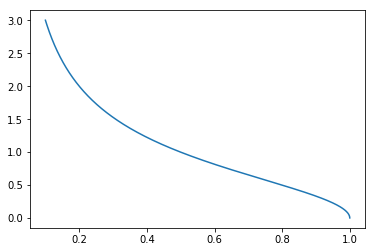

In [165]:
plt.figure()
plt.plot(lorentzian(z[z>0]),z[z>0])

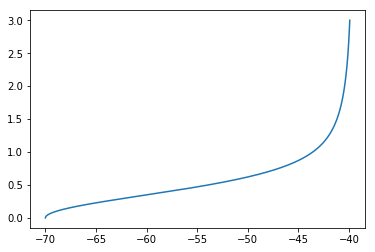

In [166]:
plt.figure()
plt.plot(V[500,:],intensity)

In [167]:
fwhm = compute_fwhm(100,100)

In [168]:
tlim = t.size
ilim = intensity.size
S = np.zeros((ilim,tlim))
for i in range(ilim):
    for j in range(tlim):
        S[i,j] = compute_fwhm(i,j)

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


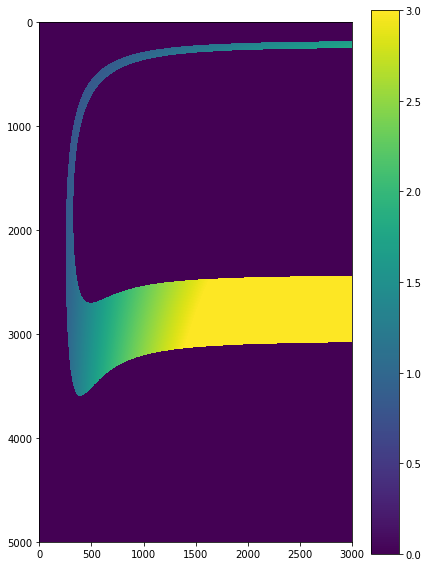

In [169]:
plt.figure(figsize=(7,10))
# plt.subplot(1,2,1)
plt.imshow((S.T)*(np.abs(V-thresh)<2))
plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(V)
# plt.colorbar()

In [189]:
spreadbyintensity = np.zeros(intensity.size)
towait = np.zeros(intensity.size)
for i in range(intensity.size):
    try:
        towait[i] = np.interp(thresh,V[:,i][:np.argmax(V[:,i])],t[:np.argmax(V[:,i])])
    except:
        towait[i] = np.nan
    spreadbyintensity[i] = np.interp(towait[i],t,S[i,:])

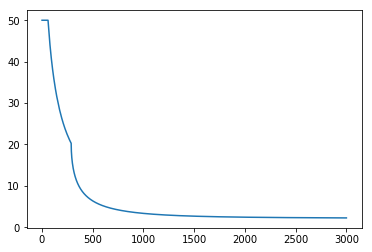

In [192]:
plt.plot(towait)

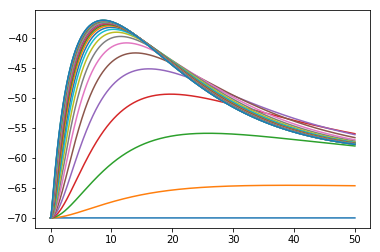

In [201]:
plt.figure()
i = 100
# plt.plot(V[:,i][:np.argmax(V[:,i])])
plt.plot(t,V[:,::100])

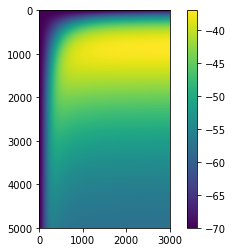

In [178]:
plt.figure()
plt.imshow(V)
plt.colorbar()

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


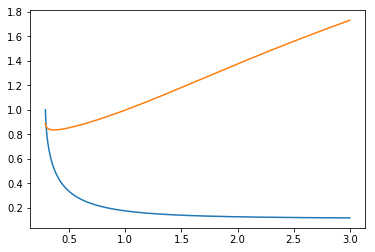

In [208]:
plt.figure()
# plt.plot(towait/towait.max())
gd = towait<0.4*np.nanmax(towait)
plt.plot(intensity[gd],towait[gd]/np.nanmax(towait[gd]))
plt.plot(intensity[gd],spreadbyintensity[gd])
plt.savefig('timing_and_spread.eps')

In [194]:
gd = towait<np.nanmax(towait)
gd

/home/mossing/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([False, False, False, ...,  True,  True,  True], dtype=bool)

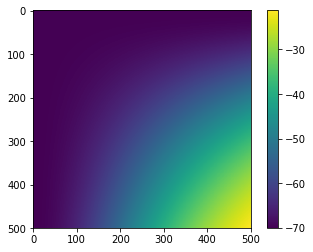

In [95]:
plt.figure()
plt.imshow(V[:500,:500])
plt.colorbar()

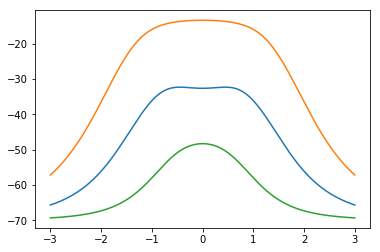

In [56]:


Vtgt = 20

stoptime = -1
peakintensity = np.argmin(np.abs(V[stoptime]-Vtgt))
vals = np.interp(1.2*intensity[peakintensity]*lorentzian(z),intensity,V[stoptime,:])
plt.plot(z,vals)

stoptime = 250
peakintensity = np.argmin(np.abs(V[stoptime]-Vtgt))
vals = np.interp(intensity[peakintensity]*lorentzian(z),intensity,V[stoptime,:])
plt.plot(z,vals)

stoptime = 50
peakintensity = np.argmin(np.abs(V[stoptime]-Vtgt))
vals = np.interp(intensity[peakintensity]*lorentzian(z),intensity,V[stoptime,:])
plt.plot(z,vals)

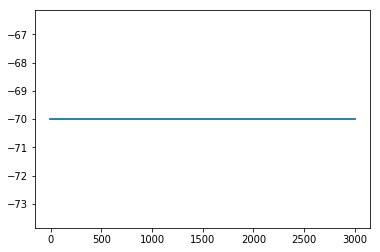

In [213]:
plt.figure()
# at various times, plot the intensity vs. depolarization curve
plt.plot(V[::100,:].T)

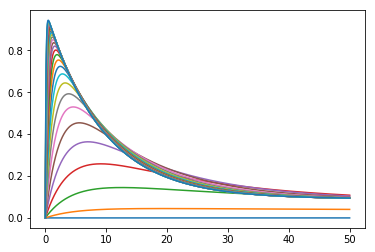

In [61]:
plt.figure()
# at various intensities, plot the time vs. depolarization curve
plt.plot(t,Copen[:,::100])

need to figure out the combination of intensity and waiting time that maximizes the squareness of the intensity dependence while still ensuring a spike at the desired location. Is it slow and low intensity, or fast and high intensity?

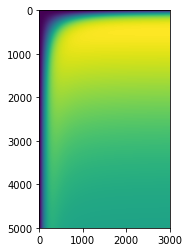

In [59]:
plt.figure()
plt.imshow(V)

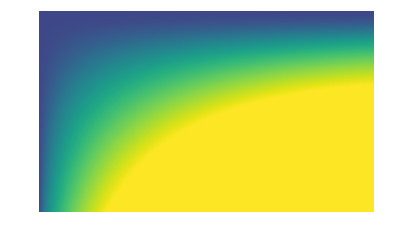

In [217]:
plt.figure()
plt.imshow(S)
plt.axis('off')
plt.savefig('fwhm_intensity_time.eps')

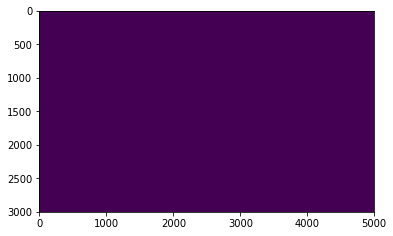

In [212]:
plt.figure()
plt.imshow(V.T)

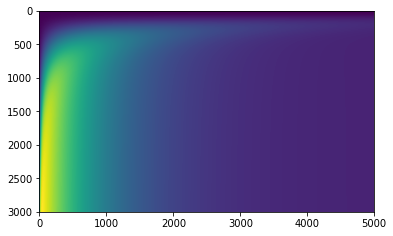

In [219]:
plt.figure()
plt.imshow(Copen.T)

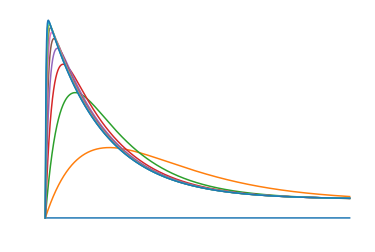

In [224]:
plt.figure()
plt.plot(Copen[:,::300])
plt.axis('off')
plt.savefig('current_v_time_inactivating.eps')